# Requirements

In [1]:
import os
import numpy as np
import glob
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

# Image Preprocessing

In [14]:
train_dir="/content/drive/My Drive/dm_project/real_fake_images/train"
val_dir="/content/drive/My Drive/dm_project/real_fake_images/valid"

<ipython-input-61-f4db91a10d14>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(sizes.keys()), y=list(sizes.values()), palette='coolwarm')


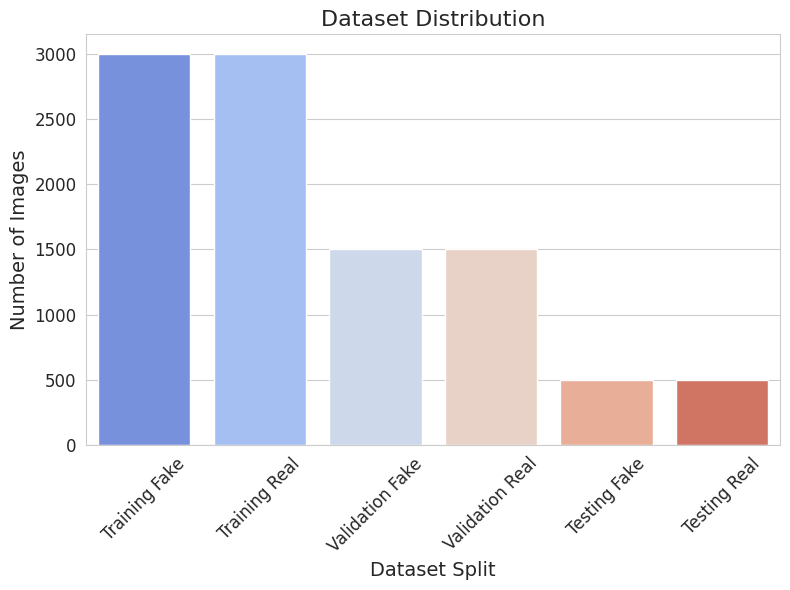

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define dataset sizes
sizes = {
    'Training Fake': 3000,
    'Training Real': 3000,
    'Validation Fake': 1500,
    'Validation Real': 1500,
    'Testing Fake': 500,
    'Testing Real': 500
}

# Create a bar plot using Seaborn with enhanced styling
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(x=list(sizes.keys()), y=list(sizes.values()), palette='coolwarm')
plt.title('Dataset Distribution', fontsize=16)
plt.xlabel('Dataset Split', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [4]:
batch_size=100
img_size=128

In [17]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()


In [16]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.15,
      height_shift_range=0.15,
      zoom_range=0.3,
      horizontal_flip=True,
      )

train_data=image_gen_train.flow_from_directory(batch_size=batch_size,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(img_size,img_size),
                                               class_mode='binary')

Found 6000 images belonging to 2 classes.


In [18]:
class_indices = train_data.class_indices
print(class_indices)

{'fake': 0, 'real': 1}


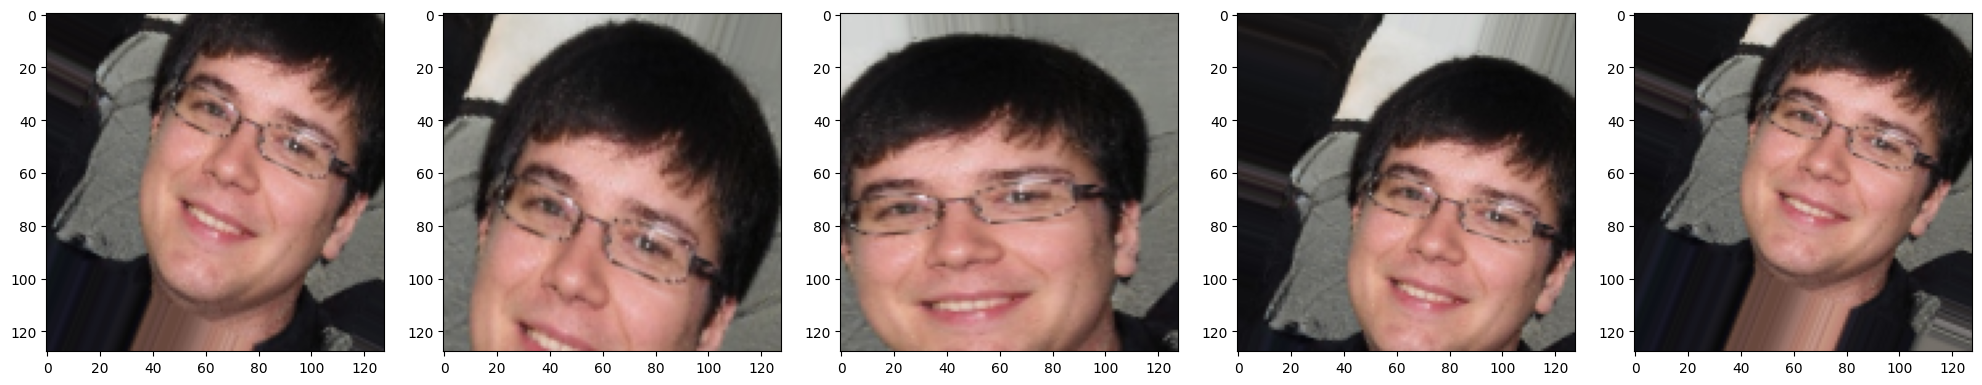

In [19]:
augmented_images = [train_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [20]:
image_gen_val = ImageDataGenerator(
      rescale=1./255,)

val_data=image_gen_val.flow_from_directory(batch_size=batch_size,
                                               directory=val_dir,
                                               target_size=(img_size,img_size),
                                               class_mode='binary')

Found 3000 images belonging to 2 classes.


In [21]:
class_indices = val_data.class_indices
print(class_indices)

{'fake': 0, 'real': 1}


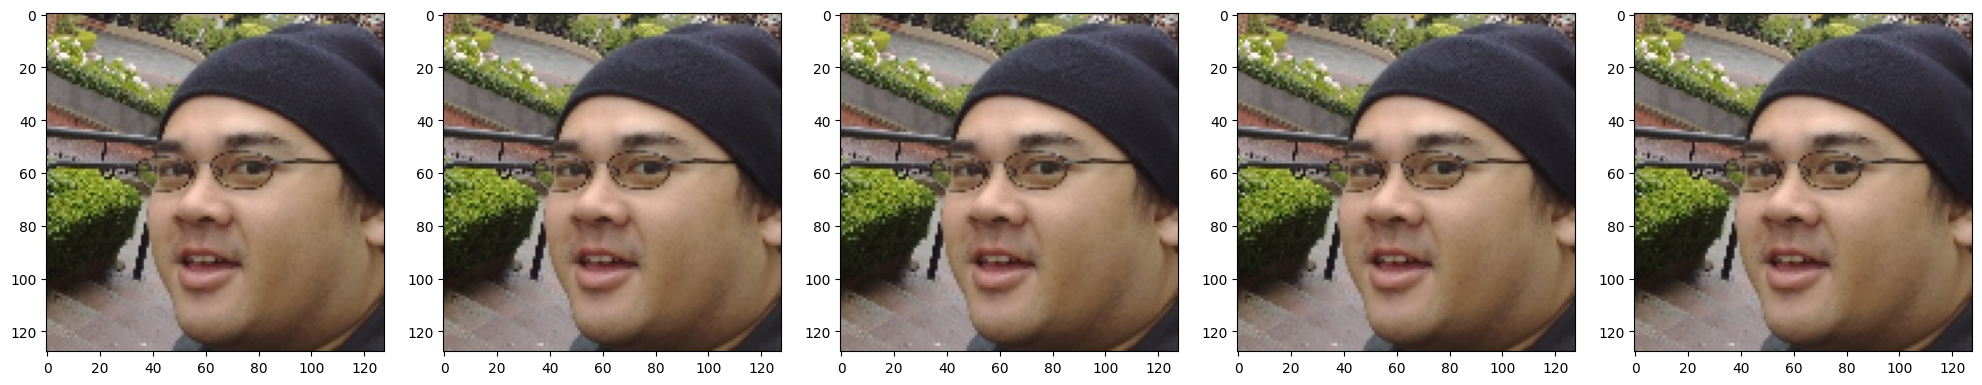

In [22]:
augmented_images = [val_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Applying Models

## CNN

### CNN Architecture

In [24]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(img_size,img_size,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])

In [22]:
! pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 7.3 MB/s eta 0:00:00


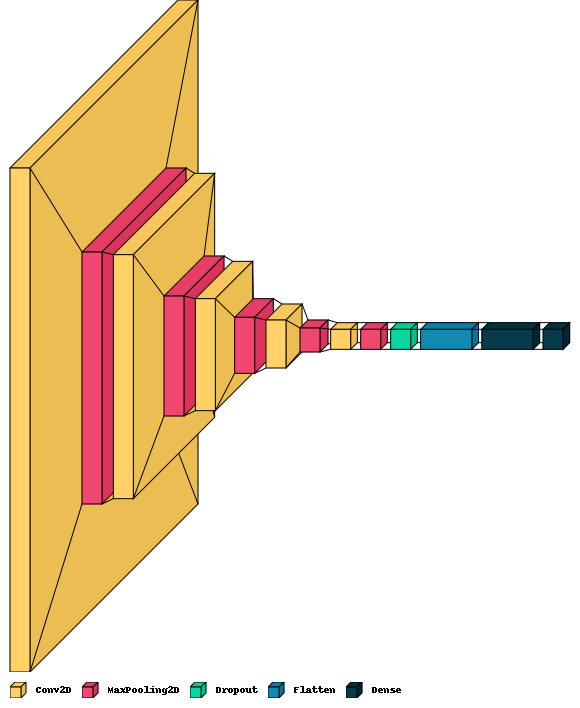

In [30]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, legend=True)  # font is optional!

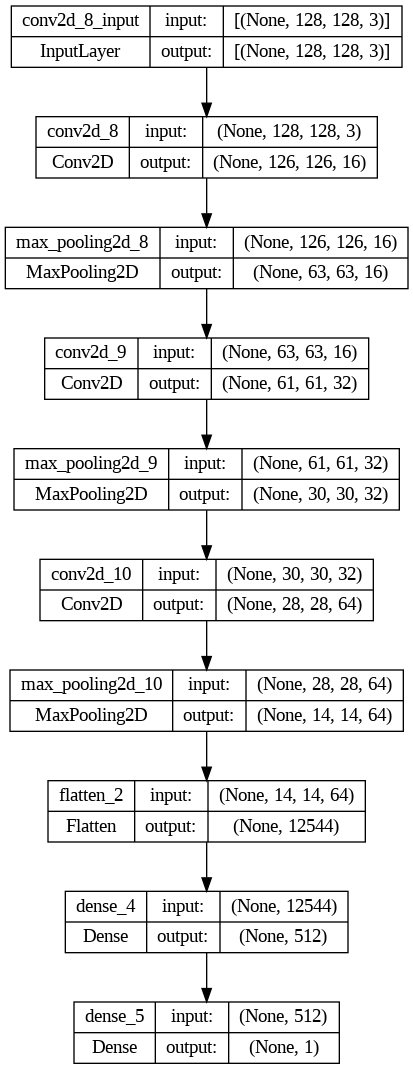

In [11]:
# Plot the model architecture
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=0)


In [ ]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
               metrics=['accuracy'] )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

### CNN training

In [ ]:
epochs=10
history=model.fit(train_data,validation_data=val_data,epochs=epochs)

Epoch 1/10
60/60 [==============================] - 71s 1s/step - loss: 0.6932 - accuracy: 0.5045 - val_loss: 0.6917 - val_accuracy: 0.5297
Epoch 2/10
60/60 [==============================] - 64s 1s/step - loss: 0.6923 - accuracy: 0.5135 - val_loss: 0.7017 - val_accuracy: 0.5000
Epoch 3/10
60/60 [==============================] - 63s 1s/step - loss: 0.6927 - accuracy: 0.5105 - val_loss: 0.6911 - val_accuracy: 0.5227
Epoch 4/10
60/60 [==============================] - 66s 1s/step - loss: 0.6873 - accuracy: 0.5445 - val_loss: 0.6761 - val_accuracy: 0.5777
Epoch 5/10
60/60 [==============================] - 63s 1s/step - loss: 0.6849 - accuracy: 0.5552 - val_loss: 0.6757 - val_accuracy: 0.5710
Epoch 6/10
60/60 [==============================] - 56s 935ms/step - loss: 0.6788 - accuracy: 0.5760 - val_loss: 0.6843 - val_accuracy: 0.5407
Epoch 7/10
60/60 [==============================] - 54s 906ms/step - loss: 0.6744 - accuracy: 0.5740 - val_loss: 0.6708 - val_accuracy: 0.5890
Epoch 8/10
60/

In [ ]:
model.save('/content/drive/My Drive/dm_project/trained_models/cnn/rf_images_cnn_b100_i128.h5')

Total trained on 80 Epochs by parts

In [37]:
epochs = 20
# Load the saved model
loaded_model = load_model('/content/drive/My Drive/dm_project/trained_models/cnn/rf_images_cnn_b100_i128.h5')

# Compile the loaded model with the appropriate optimizer, loss function, and metrics
loaded_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Assuming you have your training data ready in 'train_data' and other required parameters defined
# Train the model using the fit method
history = loaded_model.fit(train_data,validation_data=val_data,epochs=epochs)


# Optionally, you can save the retrained model again
loaded_model.save('/content/drive/My Drive/dm_project/trained_models/cnn/rf_images_cnn_b100_i128.h5')

Epoch 1/20
60/60 [==============================] - 62s 980ms/step - loss: 0.4643 - accuracy: 0.7853 - val_loss: 0.4833 - val_accuracy: 0.7737
Epoch 2/20
60/60 [==============================] - 59s 989ms/step - loss: 0.4561 - accuracy: 0.7903 - val_loss: 0.4899 - val_accuracy: 0.7663
Epoch 3/20
60/60 [==============================] - 60s 997ms/step - loss: 0.4504 - accuracy: 0.7905 - val_loss: 0.5254 - val_accuracy: 0.7490
Epoch 4/20
60/60 [==============================] - 71s 1s/step - loss: 0.4501 - accuracy: 0.7917 - val_loss: 0.4735 - val_accuracy: 0.7830
Epoch 5/20
60/60 [==============================] - 61s 1s/step - loss: 0.4614 - accuracy: 0.7882 - val_loss: 0.4868 - val_accuracy: 0.7720
Epoch 6/20
60/60 [==============================] - 59s 989ms/step - loss: 0.4452 - accuracy: 0.7915 - val_loss: 0.4929 - val_accuracy: 0.7747
Epoch 7/20
60/60 [==============================] - 59s 984ms/step - loss: 0.4389 - accuracy: 0.7865 - val_loss: 0.4861 - val_accuracy: 0.7850
Epoch

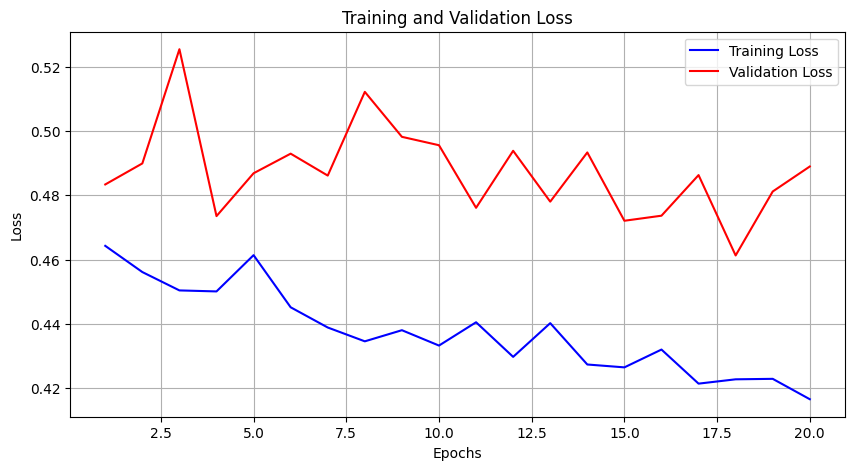

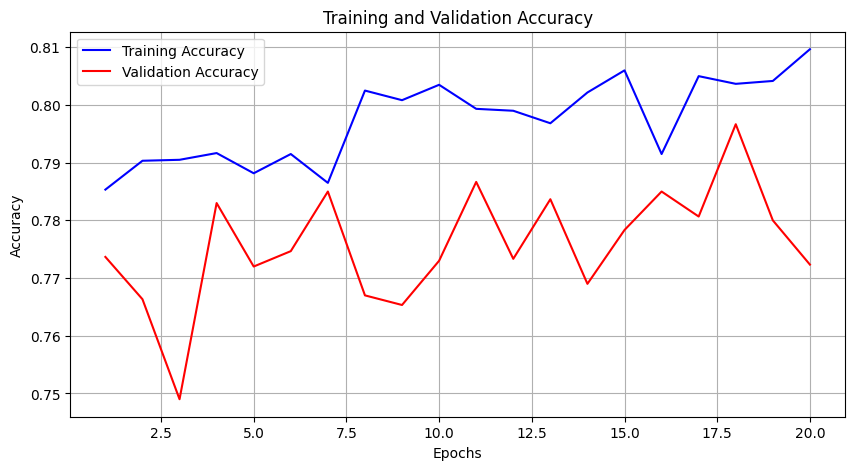

In [38]:
# Get training and validation metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating CNN model

In [53]:
loaded_model = load_model('/content/drive/My Drive/dm_project/trained_models/cnn/rf_images_cnn_b100_i128.h5')

# Define the directory containing your testing images
test_directory = "/content/drive/My Drive/dm_project/real_fake_images/test"

# Create an ImageDataGenerator instance for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for loading testing images from the directory
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_size, img_size),  # Set the target size of the images
    batch_size=batch_size,  # Adjust batch size as needed
    class_mode='binary',  # Set class_mode to 'binary' for binary classification
    shuffle=False  # No need to shuffle for evaluation
)

# Evaluate the model on the testing data
evaluation = loaded_model.evaluate(test_generator)

# Print the evaluation results
print("Testing Loss:", evaluation[0])
print("Testing Accuracy:", evaluation[1])


Found 1000 images belonging to 2 classes.
10/10 [==============================] - 4s 393ms/step - loss: 0.4734 - accuracy: 0.7720
Testing Loss: 0.4733543395996094
Testing Accuracy: 0.7720000147819519


10/10 [==============================] - 4s 365ms/step


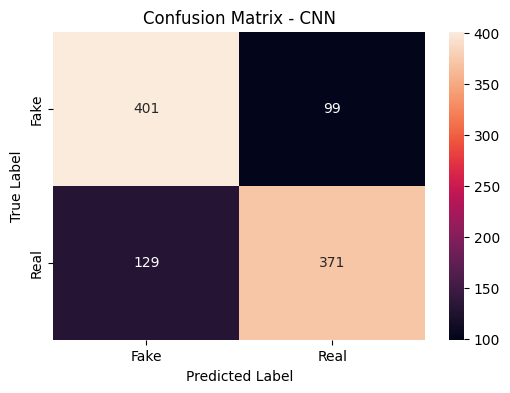

In [54]:
import seaborn as sns
# Get the true labels and predictions for the testing data
true_labels = test_generator.classes
predictions = loaded_model.predict(test_generator).flatten()

# Convert the probabilities to binary predictions (0 or 1)
binary_predictions = np.round(predictions)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Define class labels
class_labels = ['Fake', 'Real']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## MLP

### MLP Architecture

In [12]:
mlp_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(img_size, img_size, 3)),  # Flatten the input images
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
])


In [ ]:
mlp_model.compile(optimizer='adam',
              loss="binary_crossentropy",
               metrics=['accuracy'] )

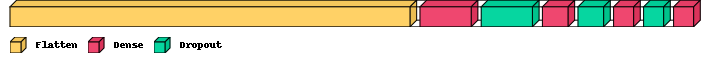

In [32]:
visualkeras.layered_view(mlp_model).show() # display using your system viewer
visualkeras.layered_view(mlp_model, legend=True)  # font is optional!

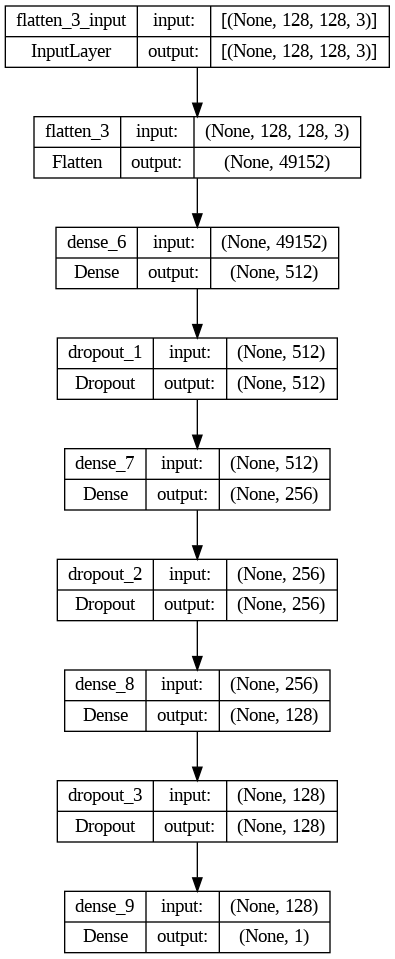

In [14]:
# Plot the model architecture
plot_model(mlp_model, to_file='mlp_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=0)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 49152)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               25166336  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)              

### MLP Training

In [ ]:
epochs=10
history=mlp_model.fit(train_data,validation_data=val_data,epochs=epochs)

Epoch 1/10
60/60 [==============================] - 53s 865ms/step - loss: 3.3611 - accuracy: 0.5122 - val_loss: 0.7573 - val_accuracy: 0.5000
Epoch 2/10
60/60 [==============================] - 53s 892ms/step - loss: 0.7949 - accuracy: 0.4975 - val_loss: 0.6930 - val_accuracy: 0.5003
Epoch 3/10
60/60 [==============================] - 46s 773ms/step - loss: 0.7281 - accuracy: 0.4990 - val_loss: 0.6963 - val_accuracy: 0.5073
Epoch 4/10
60/60 [==============================] - 45s 751ms/step - loss: 0.6957 - accuracy: 0.4933 - val_loss: 0.6933 - val_accuracy: 0.4980
Epoch 5/10
60/60 [==============================] - 46s 766ms/step - loss: 0.6938 - accuracy: 0.4883 - val_loss: 0.6934 - val_accuracy: 0.5013
Epoch 6/10
60/60 [==============================] - 46s 774ms/step - loss: 0.6934 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5077
Epoch 7/10
60/60 [==============================] - 42s 703ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5003

In [ ]:
mlp_model.save('./trained_models/mlp/rf_images_mlp_b100_i128.h5')

In [42]:
epochs = 20
# Load the saved model
loaded_model = load_model('/content/drive/My Drive/dm_project/trained_models/mlp/rf_images_mlp_b100_i128.h5')

# Compile the loaded model with the appropriate optimizer, loss function, and metrics
loaded_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Assuming you have your training data ready in 'train_data' and other required parameters defined
# Train the model using the fit method
history = loaded_model.fit(train_data,validation_data=val_data,epochs=epochs)


# Optionally, you can save the retrained model again
loaded_model.save('/content/drive/My Drive/dm_project/trained_models/mlp/rf_images_mlp_b100_i128.h5')

Epoch 1/20
60/60 [==============================] - 62s 1s/step - loss: 0.6937 - accuracy: 0.4908 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
60/60 [==============================] - 59s 989ms/step - loss: 0.6961 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/20
60/60 [==============================] - 59s 981ms/step - loss: 0.6953 - accuracy: 0.4962 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
60/60 [==============================] - 70s 1s/step - loss: 0.6938 - accuracy: 0.4975 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
60/60 [==============================] - 69s 1s/step - loss: 0.6933 - accuracy: 0.4908 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
60/60 [==============================] - 60s 1s/step - loss: 0.6944 - accuracy: 0.4963 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/20
60/60 [==============================] - 60s 1s/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/20
60/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


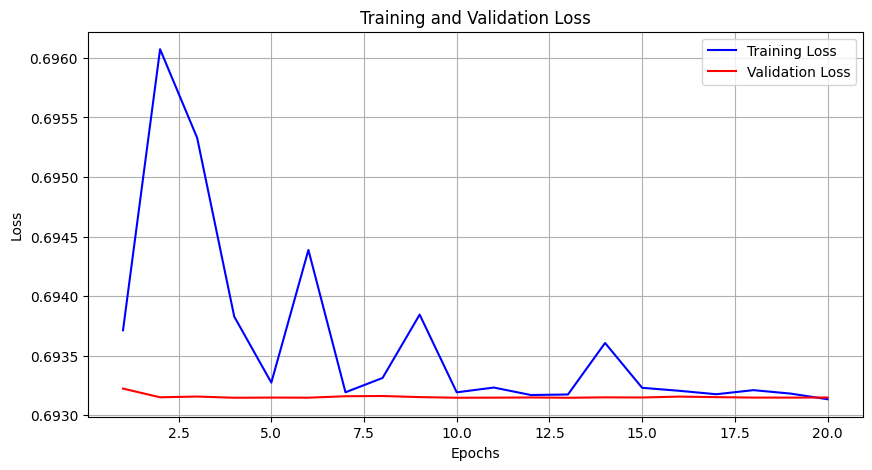

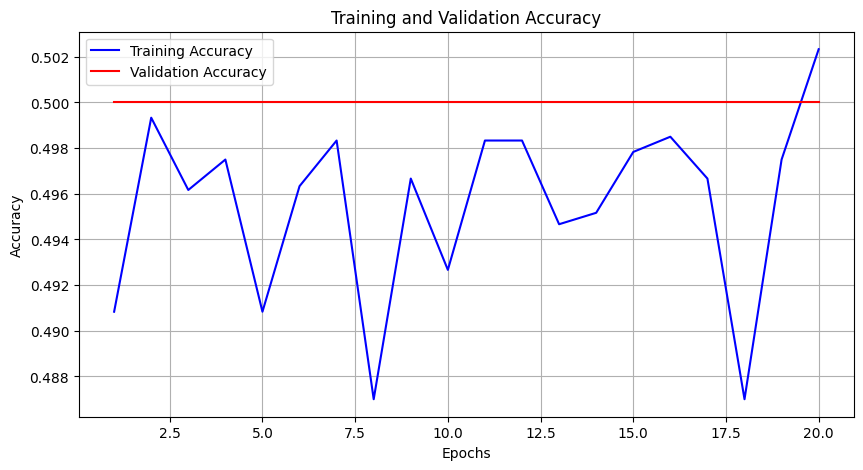

In [43]:
# Get training and validation metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Evaluating MLP

In [55]:
loaded_model = load_model('/content/drive/My Drive/dm_project/trained_models/mlp/rf_images_mlp_b100_i128.h5')

# Define the directory containing your testing images
test_directory = "/content/drive/My Drive/dm_project/real_fake_images/test"

# Create an ImageDataGenerator instance for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for loading testing images from the directory
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_size, img_size),  # Set the target size of the images
    batch_size=batch_size,  # Adjust batch size as needed
    class_mode='binary',  # Set class_mode to 'binary' for binary classification
    shuffle=False  # No need to shuffle for evaluation
)

# Evaluate the model on the testing data
evaluation = loaded_model.evaluate(test_generator)

# Print the evaluation results
print("Testing Loss:", evaluation[0])
print("Testing Accuracy:", evaluation[1])


Found 1000 images belonging to 2 classes.
10/10 [==============================] - 4s 369ms/step - loss: 0.6931 - accuracy: 0.5000
Testing Loss: 0.6931494474411011
Testing Accuracy: 0.5


10/10 [==============================] - 4s 364ms/step


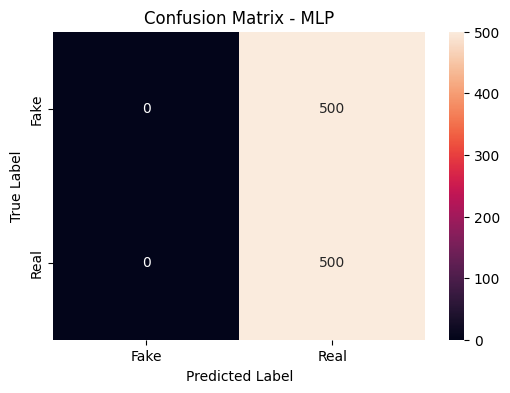

In [56]:
import seaborn as sns
# Get the true labels and predictions for the testing data
true_labels = test_generator.classes
predictions = loaded_model.predict(test_generator).flatten()

# Convert the probabilities to binary predictions (0 or 1)
binary_predictions = np.round(predictions)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Define class labels
class_labels = ['Fake', 'Real']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - MLP")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## VGG-19

### Setting Architecture

In [16]:
IMAGE_SIZE = [128, 128]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
#here [3] denotes for RGB images(3 channels)

for layer in vgg.layers:
    layer.trainable = False

vgg.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

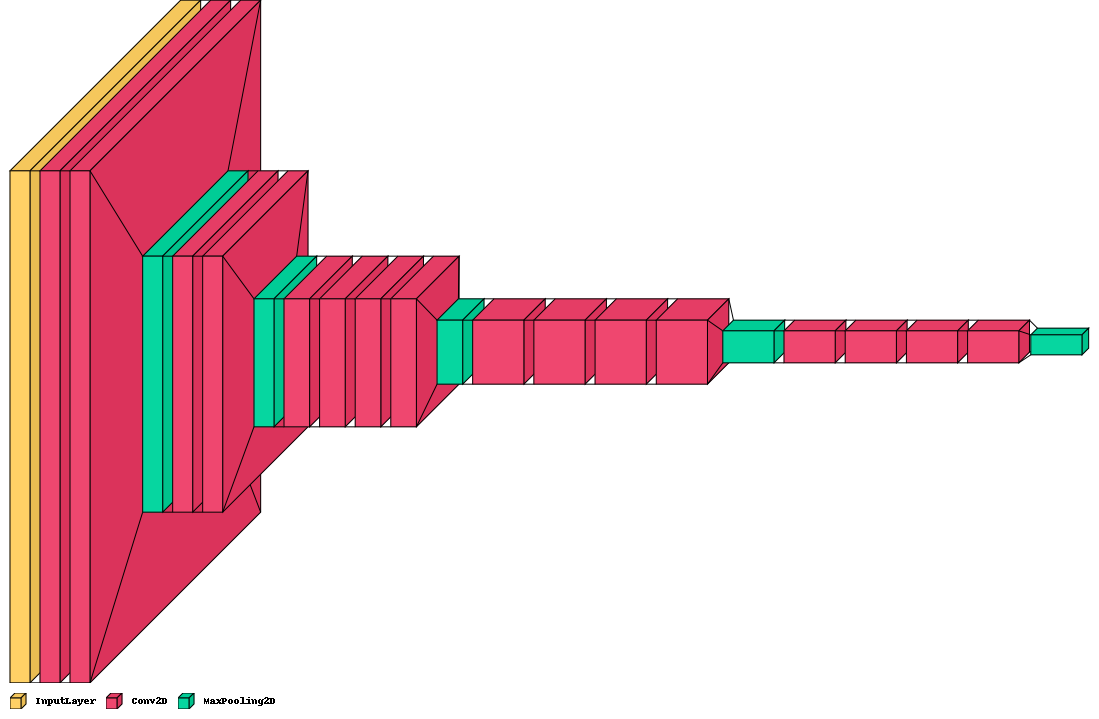

In [34]:
visualkeras.layered_view(vgg).show() # display using your system viewer
visualkeras.layered_view(vgg, legend=True)  # font is optional!

In [17]:
tf_model = tf.keras.models.Sequential()
# add vgg layers
tf_model.add(vgg)
# add flatten layer
tf_model.add(tf.keras.layers.Flatten())
# add dense layers with some dropout
tf_model.add(tf.keras.layers.Dense(256, activation='relu'))
tf_model.add(tf.keras.layers.Dropout(rate=0.3))
tf_model.add(tf.keras.layers.Dense(256, activation='relu'))
tf_model.add(tf.keras.layers.Dropout(rate=0.3))
# add output layer
tf_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [25]:
tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='binary_crossentropy',
metrics=['accuracy'])

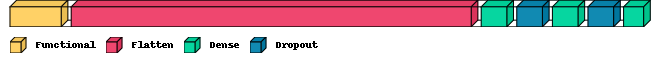

In [33]:
visualkeras.layered_view(tf_model).show() # display using your system viewer
visualkeras.layered_view(tf_model, legend=True)  # font is optional!

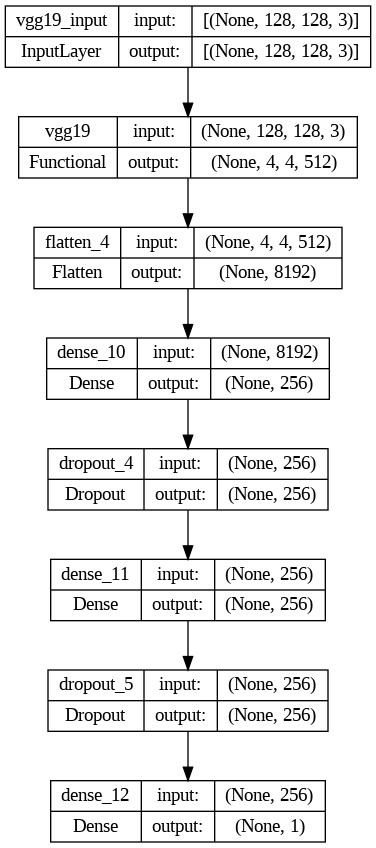

In [18]:
# Plot the model architecture
plot_model(tf_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True, rankdir='TB', dpi=0)


In [26]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
patience=3,
restore_best_weights=True,
verbose=1)

### tf_model Training

In [28]:
epochs=10
history=tf_model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[callback])

Epoch 1/10
60/60 [==============================] - 79s 1s/step - loss: 0.7241 - accuracy: 0.5263 - val_loss: 0.6678 - val_accuracy: 0.6057
Epoch 2/10
60/60 [==============================] - 71s 1s/step - loss: 0.6893 - accuracy: 0.5603 - val_loss: 0.6477 - val_accuracy: 0.6310
Epoch 3/10
60/60 [==============================] - 64s 1s/step - loss: 0.6755 - accuracy: 0.5750 - val_loss: 0.6544 - val_accuracy: 0.6013
Epoch 4/10
60/60 [==============================] - 62s 1s/step - loss: 0.6724 - accuracy: 0.5887 - val_loss: 0.6531 - val_accuracy: 0.6040
Epoch 4: early stopping


In [32]:
loaded_model.save('/content/drive/My Drive/dm_project/trained_models/vgg/rf_images_vgg_b100_i128.h5')

Model trained on 50 epochs by part

In [49]:
epochs = 20
# Load the saved model
loaded_model = load_model('/content/drive/My Drive/dm_project/trained_models/vgg/rf_images_vgg_b100_i128.h5')

# Compile the loaded model with the appropriate optimizer, loss function, and metrics
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
loss='binary_crossentropy',
metrics=['accuracy'])

# Assuming you have your training data ready in 'train_data' and other required parameters defined
# Train the model using the fit method
history = loaded_model.fit(train_data,validation_data=val_data,epochs=epochs)


# Optionally, you can save the retrained model again
loaded_model.save('/content/drive/My Drive/dm_project/trained_models/vgg/rf_images_vgg_b100_i128.h5')

Epoch 1/20
60/60 [==============================] - 66s 1s/step - loss: 0.6101 - accuracy: 0.6632 - val_loss: 0.5806 - val_accuracy: 0.6893
Epoch 2/20
60/60 [==============================] - 72s 1s/step - loss: 0.6016 - accuracy: 0.6778 - val_loss: 0.5769 - val_accuracy: 0.6930
Epoch 3/20
60/60 [==============================] - 63s 1s/step - loss: 0.5985 - accuracy: 0.6733 - val_loss: 0.5844 - val_accuracy: 0.6873
Epoch 4/20
60/60 [==============================] - 61s 1s/step - loss: 0.6007 - accuracy: 0.6773 - val_loss: 0.5840 - val_accuracy: 0.6900
Epoch 5/20
60/60 [==============================] - 61s 1s/step - loss: 0.5945 - accuracy: 0.6820 - val_loss: 0.5769 - val_accuracy: 0.6950
Epoch 6/20
60/60 [==============================] - 61s 1s/step - loss: 0.5972 - accuracy: 0.6803 - val_loss: 0.5737 - val_accuracy: 0.6983
Epoch 7/20
60/60 [==============================] - 70s 1s/step - loss: 0.6013 - accuracy: 0.6835 - val_loss: 0.5783 - val_accuracy: 0.6967
Epoch 8/20
60/60 [==

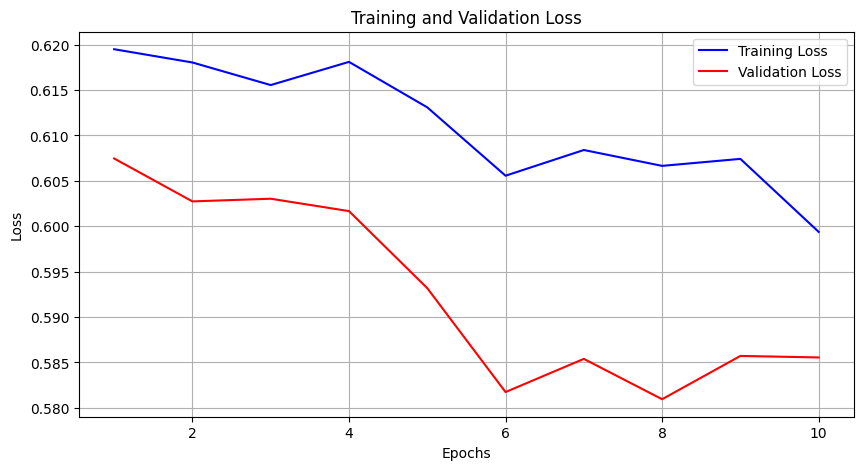

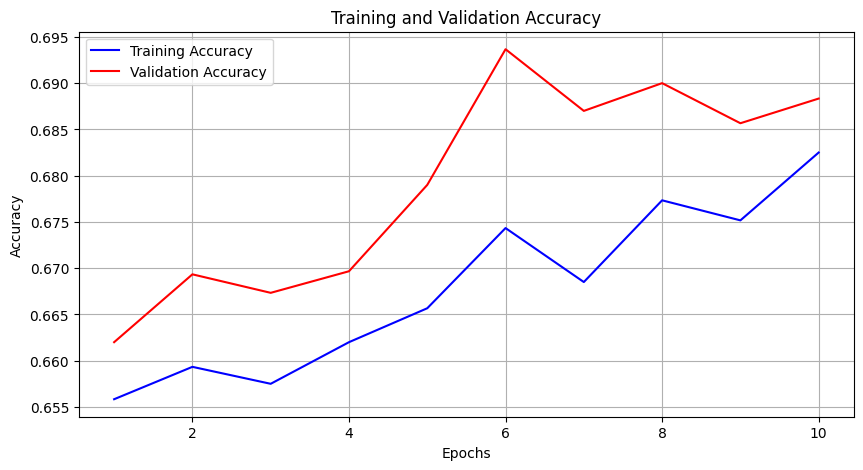

In [48]:
# Get training and validation metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### VGG Evaluation

In [50]:
loaded_model = load_model('/content/drive/My Drive/dm_project/trained_models/vgg/rf_images_vgg_b100_i128.h5')

# Define the directory containing your testing images
test_directory = "/content/drive/My Drive/dm_project/real_fake_images/test"

# Create an ImageDataGenerator instance for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for loading testing images from the directory
test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(img_size, img_size),  # Set the target size of the images
    batch_size=batch_size,  # Adjust batch size as needed
    class_mode='binary',  # Set class_mode to 'binary' for binary classification
    shuffle=False  # No need to shuffle for evaluation
)

# Evaluate the model on the testing data
evaluation = loaded_model.evaluate(test_generator)

# Print the evaluation results
print("Testing Loss:", evaluation[0])
print("Testing Accuracy:", evaluation[1])


Found 1000 images belonging to 2 classes.
10/10 [==============================] - 5s 417ms/step - loss: 0.5719 - accuracy: 0.7010
Testing Loss: 0.5719385147094727
Testing Accuracy: 0.7009999752044678


10/10 [==============================] - 5s 511ms/step


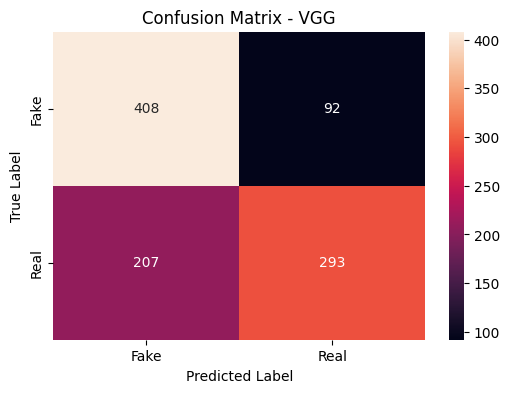

In [52]:
import seaborn as sns
# Get the true labels and predictions for the testing data
true_labels = test_generator.classes
predictions = loaded_model.predict(test_generator).flatten()

# Convert the probabilities to binary predictions (0 or 1)
binary_predictions = np.round(predictions)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, binary_predictions)

# Define class labels
class_labels = ['Fake', 'Real']

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - VGG")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
